<a href="https://colab.research.google.com/github/starvar7169/classical-quantum/blob/main/PPresearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit qiskit-aer pennylane torch matplotlib numpy scikit-learn deepspeed>=0.8.3

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes

# Create a 2-qubit variational quantum circuit (ansatz)
ansatz = RealAmplitudes(num_qubits=8, reps=1)
print(ansatz.draw())

     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
«     ┌────────────────────────────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                                                       ├
«     │                                                                                                        │
«q_1: ┤1                                                                                                       ├
«     │                                                                                                        │
«q_2: ┤2                                                                                                       ├
«     │                                                                                                        │
«q_3: ┤3                                                                                  

In [ ]:
import torch
import pennylane as qml
from torch.optim import Adam, RMSprop, NAdam, Adagrad
from qiskit.circuit.library import RealAmplitudes
import time
from deepspeed.ops.adam import FusedAdam

# Create a 8-qubit variational quantum circuit (ansatz)
n_qubits = 8
ansatz = RealAmplitudes(num_qubits=n_qubits, reps=1)
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch", diff_method="backprop")
def circuit(params):
    for i in range(n_qubits):
        qml.RY(params[:, i], wires=i)  # Use all 8 parameters in batch
    for i in range(n_qubits-1):
        qml.CNOT(wires=[i, i+1])    # Entangle all qubits
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))  # Measure correlation

# Initialize parameters on GPU
batch_size = 100  # Number of parallel circuits
params = torch.randn(batch_size, n_qubits, requires_grad=True, device='cuda')
optimizer = FusedAdam([params], lr=0.01)

# Warm-up (GPU initialization)
_ = circuit(torch.randn(batch_size, n_qubits, device='cuda'))

# GPU Benchmark
start = time.time()
losses = []
for epoch in range(100):
    optimizer.zero_grad()
    energy = circuit(params)
    loss = -energy.mean()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
gpu_time = time.time() - start

# CPU Benchmark
params_cpu = params.cpu()
start = time.time()
losses = []
for epoch in range(100):
    optimizer.zero_grad()
    energy = circuit(params)
    loss = -energy.mean()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
cpu_time = time.time() - start

print(f"GPU Time: {gpu_time:.2f}s | CPU Time: {cpu_time:.2f}s")

GPU Time: 3.28s | CPU Time: 2.30s


In [ ]:
!pip install pennylane-lightning[gpu] --quiet

In [ ]:
!nvidia-smi

In [ ]:
import torch
import pandas as pd
import pennylane as qml
from torch.optim import Adam, RMSprop, NAdam, Adagrad
from torch.nn import Parameter
from qiskit.circuit.library import RealAmplitudes
from deepspeed.ops.adam import FusedAdam
import matplotlib.pyplot as plt
import time

# ✅ Use Lightning GPU backend if available
try:
    dev = qml.device("lightning.gpu", wires=8)
except:
    print("⚠️ Falling back to CPU backend")
    dev = qml.device("default.qubit", wires=8)

n_qubits = 8
batch_size = 100
epochs= 100

# 🔁 Define single-circuit QNode (for manual batching)
@qml.qnode(dev, interface="torch", diff_method="adjoint")
def circuit_single(p):
    for i in range(n_qubits):
        qml.RY(p[i], wires=i)
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

# 🧠 Batched forward
def circuit_batch(params):
    return torch.stack([circuit_single(p) for p in params])

# ⏱️ Compare other optimizers on GPU
optimizers = {
    "Adam": Adam,
    "RMSprop": RMSprop,
    "NAdam": NAdam,
    "Adagrad": Adagrad
}
learning_rates = [0.001, 0.01, 0.1, 0.5]
results = {}
for opt_name, opt_class in optimizers.items():
    for lr in learning_rates:
        print(f"⏳ Running {opt_name} with LR={lr}...")
        torch.cuda.empty_cache()
        params = Parameter(torch.randn(batch_size, n_qubits, device="cuda"))
        optimizer = opt_class([params], lr=lr)
        energy_list = []

        torch.cuda.synchronize()
        start = time.time()

        for epoch in range(epochs):
            optimizer.zero_grad()
            energy = circuit_batch(params)
            loss = -energy.mean()
            loss.backward()
            optimizer.step()
            energy_list.append(energy.mean().item())

        torch.cuda.synchronize()
        total_time = time.time() - start

        results[(opt_name, lr)] = {
            "energies": energy_list,
            "time": total_time
        }

# 📊 Plot energy vs epoch
plt.figure(figsize=(12, 7))
for key, val in results.items():
    plt.plot(val["energies"], label=f"{key[0]} | lr={key[1]}")
plt.xlabel("Epoch")
plt.ylabel("Energy")
plt.title("Energy vs Epochs for Optimizer + Learning Rate")
plt.legend()
plt.grid(True)
plt.show()

# 📋 Tabular summary
df = pd.DataFrame([
    {"Optimizer": k[0], "Learning Rate": k[1], "Final Energy": v["energies"][-1], "Time (s)": round(v["time"], 2)}
    for k, v in results.items()
]).sort_values(by="Final Energy", ascending=False)

print("\n🔍 Comparative Summary:")
print(df)

⚠️ Falling back to CPU backend
⏳ Running Adam with LR=0.001...
⏳ Running Adam with LR=0.01...
⏳ Running Adam with LR=0.1...
⏳ Running RMSprop with LR=0.001...


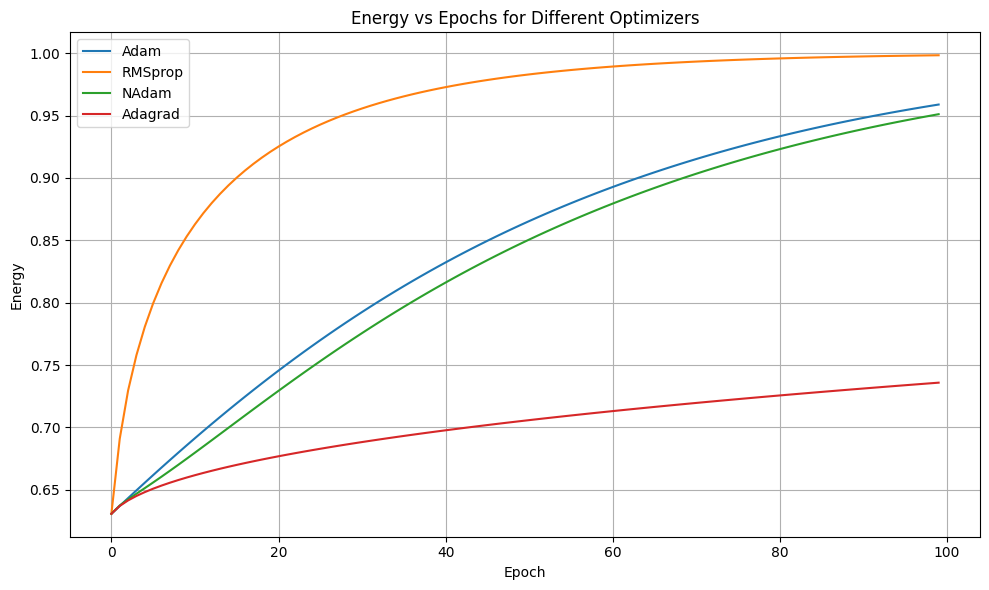

In [ ]:
import time
import matplotlib.pyplot as plt

results = {}
energy_history = {}

for opt_name, opt_class in [('Adam', Adam), ('RMSprop', RMSprop), ('NAdam', NAdam), ('Adagrad', Adagrad)]:
    # Initialize optimizer
    optimizer = opt_class([params.clone().detach().requires_grad_()], lr=0.01)
    energy_list = []

    # Training
    for epoch in range(100):
        optimizer.zero_grad()
        energy = circuit_single(optimizer.param_groups[0]['params'][0])
        loss = -energy.mean()
        loss.backward()
        optimizer.step()

        # Store energy at each epoch
        energy_list.append(energy.mean().item())

    # Save total training time and energy history
    results[opt_name] = sum(energy_list)  # You can also keep track of time if needed
    energy_history[opt_name] = energy_list

# Plotting the energy comparison
plt.figure(figsize=(10, 6))
for opt_name, energies in energy_history.items():
    plt.plot(energies, label=opt_name)

plt.title('Energy vs Epochs for Different Optimizers')
plt.xlabel('Epoch')
plt.ylabel('Energy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
speedup = cpu_time / gpu_time
print(f"Speedup: {speedup:.2f}x faster on GPU")